In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()

In [2]:
df = pd.read_csv(r"C:\Users\vaishu\Desktop\IITH\assignments\PRML\Dataset\BTC-USD.csv")

# Extract specific columns
columns_to_extract = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']  # Replace with your column names
extracted_columns = df[columns_to_extract]

# Display the extracted columns
print(extracted_columns)

df['Date']=pd.to_datetime(df['Date']).dt.tz_localize(None)
df['Mean'] = (df['Low'] + df['High'])/2
df=df.dropna()

            Date          Open          High           Low         Close  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
2708  2022-02-15  42586.464844  44667.218750  42491.035156  44575.203125   
2709  2022-02-16  44578.277344  44578.277344  43456.691406  43961.859375   
2710  2022-02-17  43937.070313  44132.972656  40249.371094  40538.011719   
2711  2022-02-18  40552.132813  40929.152344  39637.617188  40030.976563   
2712  2022-02-19  40022.132813  40246.027344  40010.867188  40126.429688   

           Volume  
0        21056800  
1        34483200  
2        37919700  
3      

In [3]:
# Creating a copy for making small changes
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual'] = dataset_for_prediction['Mean'].shift()
dataset_for_prediction = dataset_for_prediction.dropna()

# Set date as index
dataset_for_prediction.index = pd.to_datetime(dataset_for_prediction['Date'])


In [14]:
# Normalizing the exogenous variables
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High', 'Open', 'Close', 'Volume', 'Mean']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index, columns=['Low', 'High', 'Open', 'Close', 'Volume', 'Mean'])

# Normalizing the target variable
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y=scaler_output
y.rename(columns={0:'BTC Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
print("Normalized y")
print(y.head())

Normalized y
            BTC Price next day
Date                          
2014-09-18            0.003904
2014-09-19            0.003528
2014-09-20            0.003100
2014-09-21            0.003106
2014-09-22            0.003049


In [16]:
# Train-test split (without shuffling, as this is a time series)
train_size = int(len(df) * 0.9)
train_X, train_y = scaled_input[:train_size], y[:train_size]
test_X, test_y = scaled_input[train_size:], y[train_size:]

# Initialize and fit the ARIMA model
model = ARIMA(train_y, exog=train_X, order=(0, 1, 1))  # ARIMA requires three parameters (p, d, q)
results = model.fit()

# Get predictions
predictions = results.predict(start=train_size, end=train_size+len(test_y)-1, exog=test_X)


In [17]:
# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)

# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

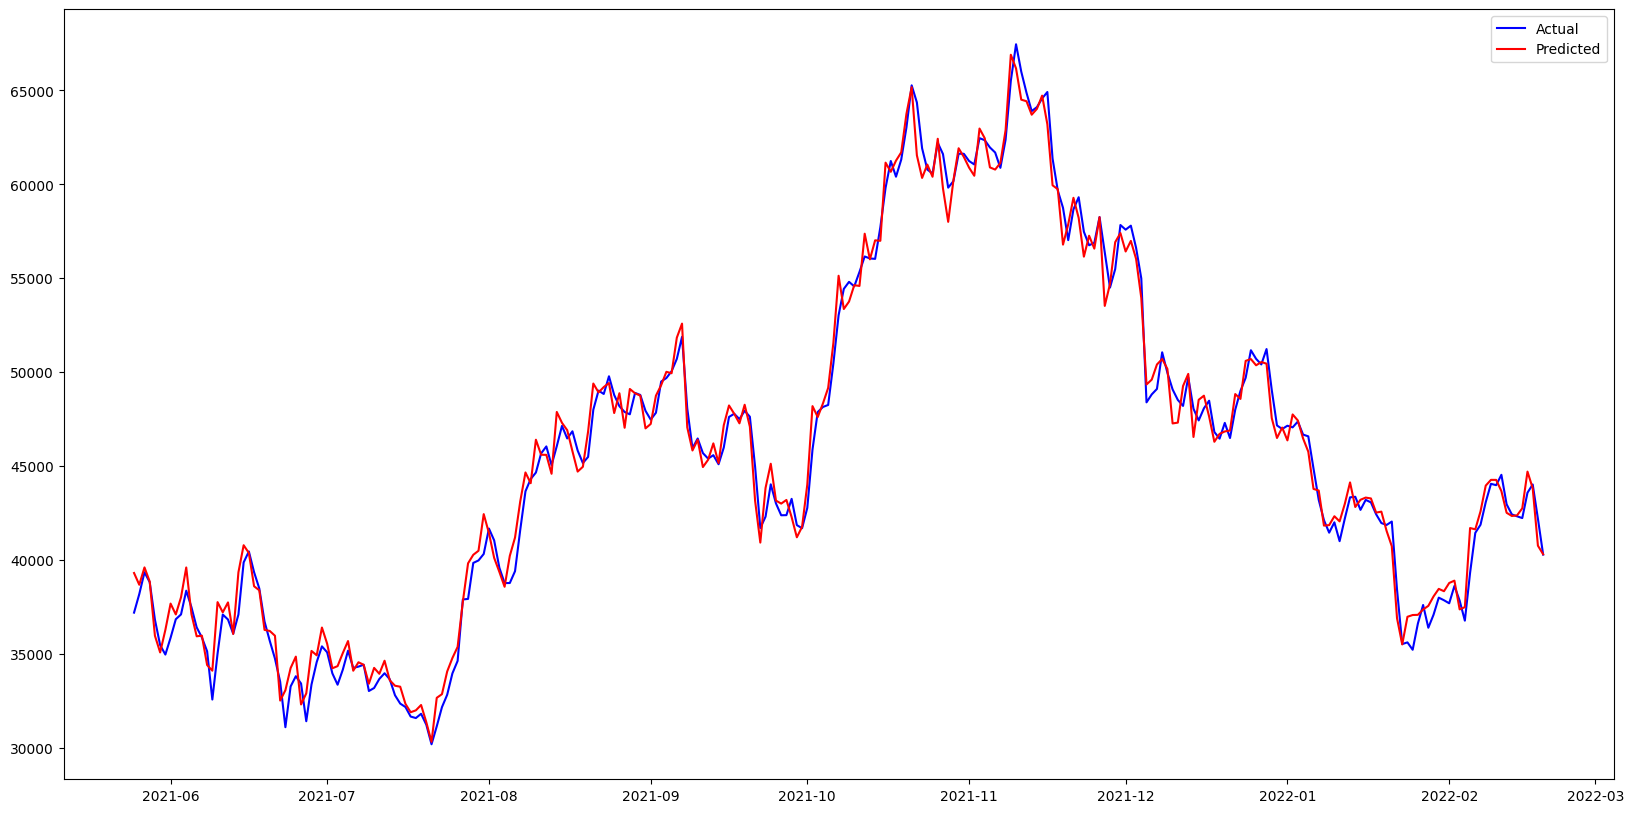

RMSE: [944.93024958]


In [18]:
# Plot predictions vs. actual values
plt.figure(figsize=(20, 10))
plt.plot(predictions_df.index, testActual, label='Actual', color='blue')
plt.plot(predictions_df.index, testPredict, label='Predicted', color='red')
plt.legend()
plt.show()

# Calculate and print RMSE
print("RMSE:", rmse(testActual, testPredict))

In [19]:
rmse_value = rmse(testActual, testPredict)

# Calculate the mean of the actual test values
mean_actual = testActual.mean()

# Calculate relative RMSE
relative_rmse = (rmse_value / mean_actual) * 100

print(f"RMSE: {rmse_value}")
print(f"Relative RMSE: {relative_rmse[0]:.2f}%")

RMSE: [944.93024958]
Relative RMSE: 2.07%


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Mean Absolute Error (MAE)
mae = mean_absolute_error(testActual, testPredict)

# Mean Squared Error (MSE)
mse = mean_squared_error(testActual, testPredict)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
# Add a small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((testActual - testPredict) / (testActual + epsilon))) * 100

# Symmetric Mean Absolute Percentage Error (sMAPE)
smape = np.mean(2 * np.abs(testActual - testPredict) / (np.abs(testActual) + np.abs(testPredict) + epsilon)) * 100

# Print all metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")


Mean Absolute Error (MAE): 739.94
Mean Squared Error (MSE): 892893.18
Root Mean Square Error (RMSE): 944.93
Mean Absolute Percentage Error (MAPE): 1.69%
Symmetric Mean Absolute Percentage Error (sMAPE): 1.68%
